In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from scipy.stats import norm

### Data

In [2]:
df = pd.read_csv("data/tsla_options.csv")
df['days_to_expiry'] = df.days_to_expiry + 1
df['mid_price'] = ((df.bid_price + df.ask_price) * 0.5).values

### Newton's Method

In [3]:
def blackscholes(S, K, T, v, r, q, t):
    
    d1 = np.log(S / K) + (r - q + v * v * 0.5) * T
    d1 /= v * np.sqrt(T)
    d2 = d1 - v * np.sqrt(T)
    
    price = t * S * np.exp(-q * T) * norm.cdf(t * d1)
    price -= t * K * np.exp(-r * T) * norm.cdf(t * d2)
    
    return price

def vega(S, K, T, v, r, q, t):
    
    d1 = np.log(S / K) + (r - q + v * v * 0.5) * T
    d1 /= v * np.sqrt(T)
    
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

### Params

In [11]:
M = df.mid_price
L = df.option_price.values
S = df.stock_price.values
K = df.strike_price.values
T = df.days_to_expiry.values / 365
v = df.implied_volatility.values / 100
r = df.rate.values / 100
q = df.dividend_yield.values / 100
t = df.option_type.map({"C" : 1, "P" : -1})

In [12]:
r

array([1.46667e-06, 1.46667e-06, 1.46667e-06, ..., 1.55083e-05,
       1.55083e-05, 1.55083e-05])

### Rate Sensitivity

In [6]:
def solve(r):
    
    v = pd.Series([0.5]*len(df))

    for i in range(20):

        e = (blackscholes(S, K, T, v, r, q, t) - M) / vega(S, K, T, v, r, q, t)
        v = v - e
        
    return v

In [7]:
vols = []
rates = []

for i in range(100):
    
    print("Solving", i)
    
    vols.append(solve(r + 0.005 * i))
    rates.append(r + 0.005 * i)

Solving 0


/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


Solving 1
Solving 2
Solving 3
Solving 4
Solving 5
Solving 6
Solving 7
Solving 8
Solving 9
Solving 10
Solving 11
Solving 12
Solving 13
Solving 14
Solving 15
Solving 16
Solving 17
Solving 18
Solving 19
Solving 20
Solving 21
Solving 22
Solving 23
Solving 24
Solving 25
Solving 26
Solving 27
Solving 28
Solving 29
Solving 30
Solving 31
Solving 32
Solving 33
Solving 34
Solving 35
Solving 36
Solving 37
Solving 38
Solving 39
Solving 40
Solving 41
Solving 42
Solving 43
Solving 44
Solving 45
Solving 46
Solving 47
Solving 48
Solving 49
Solving 50
Solving 51
Solving 52
Solving 53
Solving 54
Solving 55
Solving 56
Solving 57
Solving 58
Solving 59
Solving 60
Solving 61
Solving 62
Solving 63
Solving 64
Solving 65
Solving 66
Solving 67
Solving 68
Solving 69
Solving 70
Solving 71
Solving 72
Solving 73
Solving 74
Solving 75
Solving 76
Solving 77
Solving 78
Solving 79
Solving 80
Solving 81
Solving 82
Solving 83
Solving 84
Solving 85
Solving 86
Solving 87
Solving 88
Solving 89
Solving 90
Solving 91
Solving 

In [8]:
data = pd.DataFrame()
for i, (vol, rate) in enumerate(zip(vols, rates)):
    data[f'v{i}'] = vol
    data[f'r{i}'] = rate

In [9]:
rv = data.iloc[4000, :]
_rates = rv.values[1::2]
_vols = rv.values[0::2]

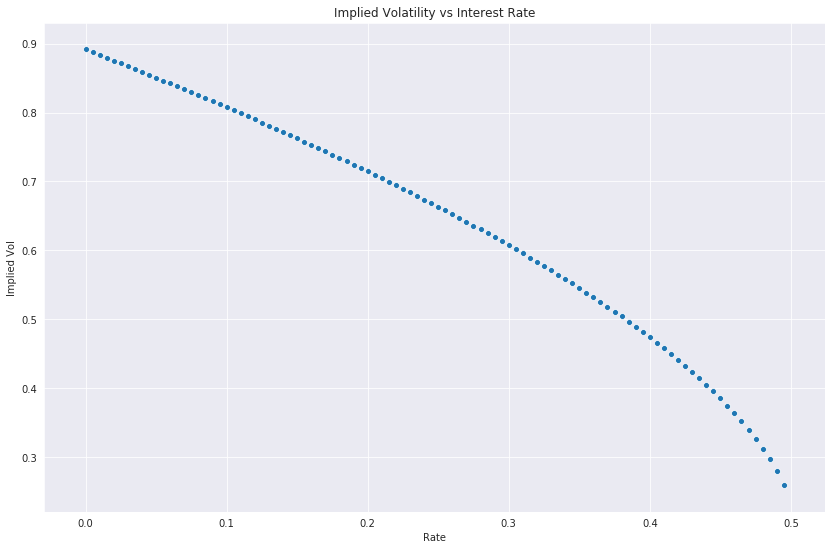

In [10]:
data = pd.DataFrame()
data['Rate'] = _rates
data['Implied Vol'] = _vols
plt.figure(figsize=(14, 9))
sns.scatterplot('Rate', 'Implied Vol', data=data)
plt.title("Implied Volatility vs Interest Rate")
plt.savefig("plots/rates_vs_iv.png")

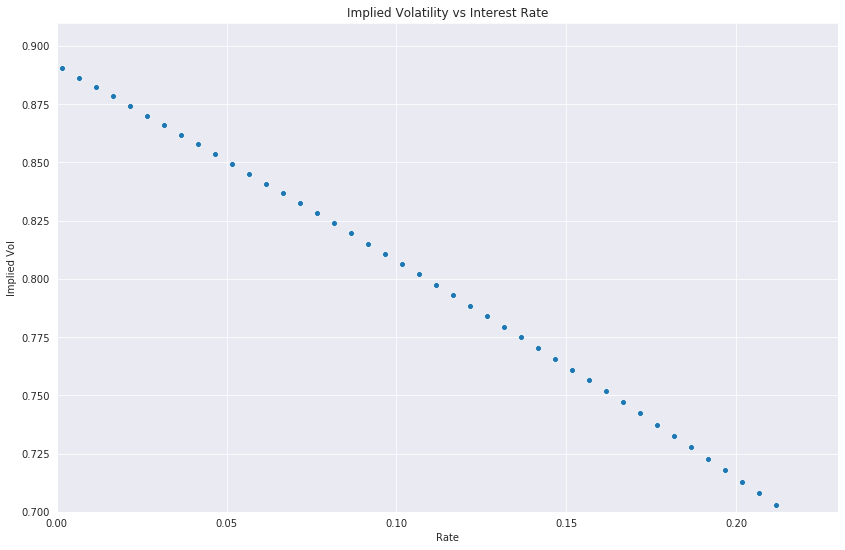

In [11]:
data = pd.DataFrame()
data['Rate'] = _rates
data['Implied Vol'] = _vols
plt.figure(figsize=(14, 9))
sns.scatterplot('Rate', 'Implied Vol', data=data)
plt.title("Implied Volatility vs Interest Rate")
plt.xlim(0, 0.23)
plt.ylim(0.7, 0.91)
plt.savefig("plots/rates_vs_iv_zoom.png")

### Calendar Days vs Trading Days 

In [12]:
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date='2012-07-01', end_date='2012-07-10')

In [13]:
date_pairs = df[['date_current', 'expiration_date']].drop_duplicates()
date_pairs['trading_days_to_expiry'] = date_pairs.apply(lambda x: nyse.schedule(start_date=x.date_current, end_date=x.expiration_date).shape[0], axis=1)
df = df.merge(date_pairs, on=['date_current', 'expiration_date'])

In [15]:
M = ((df.bid_price + df.ask_price) * 0.5).values
L = df.option_price.values
S = df.stock_price.values
K = df.strike_price.values
T = df.days_to_expiry.values / 365
TT = df.trading_days_to_expiry.values / 252
v = df.implied_volatility.values / 100
r = df.rate.values
q = df.dividend_yield.values / 100
t = df.option_type.map({"C" : 1, "P" : -1})

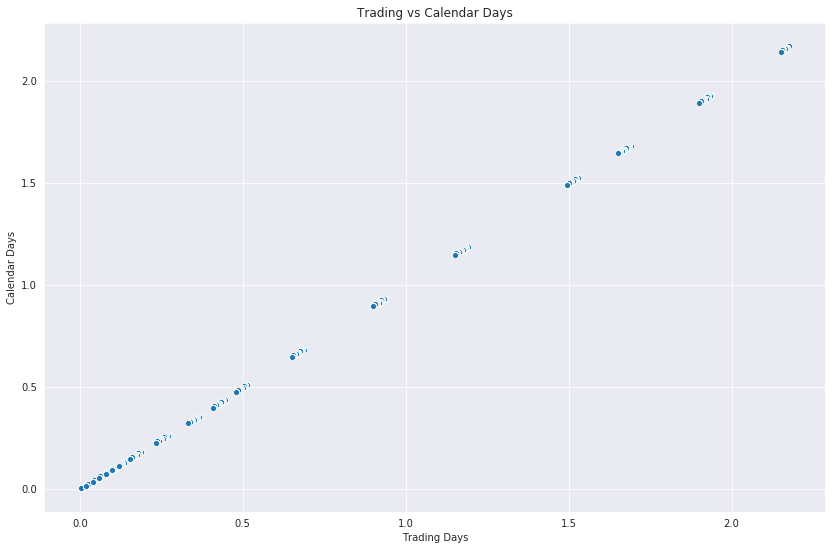

In [17]:
tmp = pd.DataFrame()
tmp['Trading Days'] = TT
tmp['Calendar Days'] = T
plt.figure(figsize=(14, 9))
sns.scatterplot('Trading Days', 'Calendar Days', data=tmp)
plt.title("Trading vs Calendar Days")
plt.savefig("plots/trading_vs_calendar_days.png")

### Forward Price vs Spot Price

In [32]:
cols = ['date_current', 'expiration_date', 'strike_price', 'rate', 'days_to_expiry','mid_price', 'option_type']
tmp = df[cols]
tmp = tmp[tmp.option_type == 'C'].merge(tmp[tmp.option_type == 'P'], on=cols[:5])

In [44]:
def find_forward(x):
    
    d = (x.mid_price_x - x.mid_price_y).abs()
    
    m = d.min()
    i = d.argmin()
    
    return x.strike_price.values[i] + np.exp(x.rate.values[i] * x.days_to_expiry.values[i]) * m
    
forward = tmp.groupby(["date_current", "expiration_date"]).apply(lambda x: find_forward(x)).reset_index()
forward.columns = ['date_current', 'expiration_date', 'forward']

In [48]:
df = df.merge(forward, on=['date_current', 'expiration_date'])

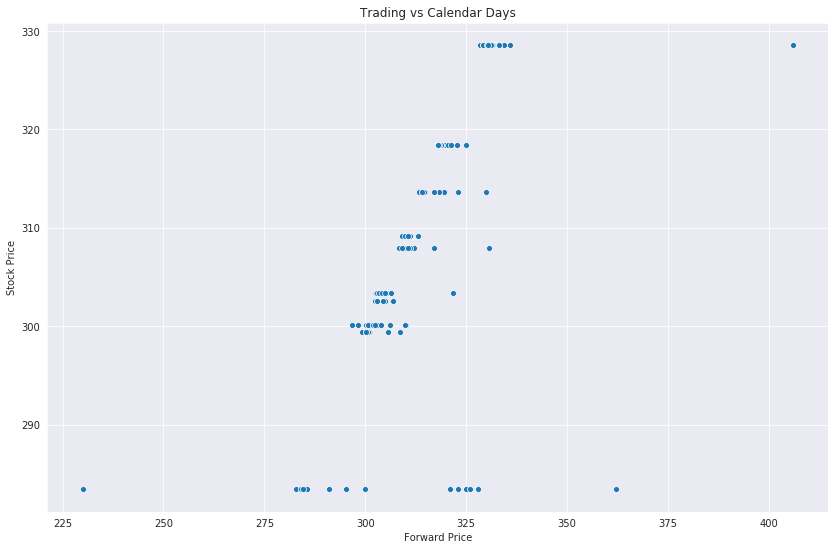

In [49]:
tmp = df[['date_current', 'expiration_date', 'stock_price', 'forward']]
tmp = tmp.drop_duplicates()
tmp['Forward Price'] = tmp.forward.values
tmp['Stock Price'] = tmp.stock_price.values
plt.figure(figsize=(14, 9))
sns.scatterplot('Forward Price', 'Stock Price', data=tmp)
plt.title("Forward vs Stock Price")
plt.savefig("plots/forward_vs_stock_price.png")

In [51]:
M = df.mid_price
L = df.option_price.values
S = df.stock_price.values
F = df.forward.values
K = df.strike_price.values
T = df.days_to_expiry.values / 365
v = df.implied_volatility.values / 100
r = df.rate.values
q = df.dividend_yield.values / 100
t = df.option_type.map({"C" : 1, "P" : -1})

In [52]:
def solve(price):
    
    v = pd.Series([0.5]*len(df))

    for i in range(20):

        e = (blackscholes(price, K, T, v, r, q, t) - M) / vega(price, K, T, v, r, q, t)
        v = v - e
        
    return v

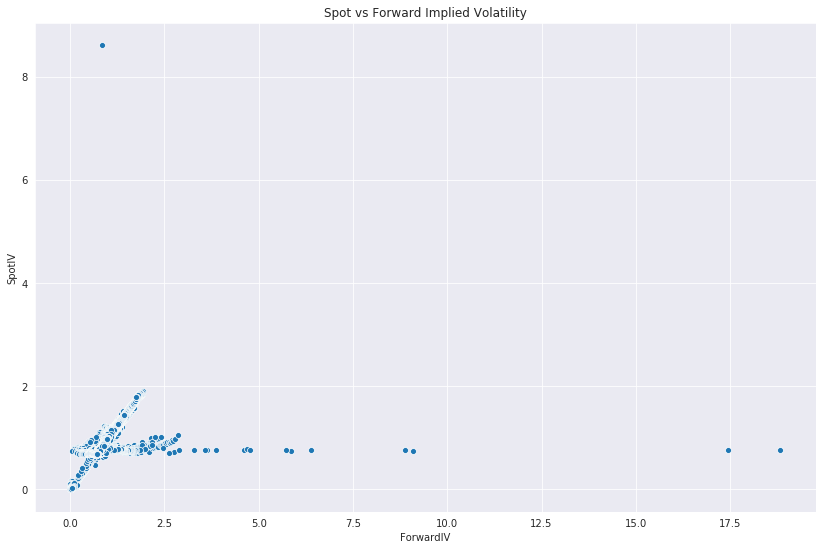

In [60]:
tmp = pd.DataFrame()

tmp['SpotIV'] = solve(S)
tmp['ForwardIV'] = solve(F)

tmp = tmp.dropna()
tmp = tmp[tmp.SpotIV > 0]
tmp = tmp[tmp.ForwardIV > 0]
tmp = tmp[tmp.SpotIV < 100]
tmp = tmp[tmp.ForwardIV < 100]

plt.figure(figsize=(14, 9))
sns.scatterplot('ForwardIV', 'SpotIV', data=tmp)
plt.title("Spot vs Forward Implied Volatility")
plt.savefig("plots/spot_vs_forward_iv.png")